# Module 11 - Convolutional Neural Networks - Lab 6

<table class="tfo-notebook-buttons" align="left">
 <td>
 <a target="_blank" href="https://colab.research.google.com/drive/1ONT6aEygsYgEyQjgx5Sblxds_KsN6_4T?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
 </td>
 <td>
 <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/blob/main/CNN/cnn_lab6.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
 </td>
</table>
<br>
<br>
<br>



Module Coordinator: Ekta Gavas

Email: ekta.gavas@research.iiit.ac.in

## Description
---
This lab is intended to provide a brief introduction to convolutional autoencoders. We will study image denoising application by adding noise to images and reconstruct the cleaner versions.

## Starter Code
---
To make your task easier, we provide you the starter code to perform the lab exercises. It is expected that you should try to understand what the code does and analyze the output. We will be using Pytorch framework for the implementation of this lab.

## Convolutional AutoEncoders
In previous modules, you have studied autoencoders (AE) for dimensionality reduction. To recall, autoencoders consists of an encoder network, which takes the input data and encodes it to fit into the latent space. These networks are trained in an unsupervised way to attempt to copy inputs to output. Because neural networks are capable of learning nonlinear relationships, this can be thought of as a more powerful (nonlinear) generalization of PCA. Whereas PCA attempts to discover a lower dimensional hyperplane which describes the original data, autoencoders are capable of learning nonlinear manifolds (a manifold is defined in simple terms as a continuous, non-intersecting surface). The difference between these two approaches is visualized below.

<img src='https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.52.21-AM.png' height=370/>

Convolutional layers can be incorporated in the encoder and decoders to learn important features from the image data (3D vectors) instead of flattened vectors (linear AE). The input image is downsampled to give a latent representation of smaller dimensions and force the autoencoder to learn a compressed version of the images. Then, it is upsampled back to reconstruct the input. Convolutional AE can be used for noise reduction where it learns to reconstruct a cleaner version of the image. The reconstructed image is compared to the original (without noise) image to compute the reconstruction loss. This way, the AE learns more robust features from image data.

<img src='https://lilianweng.github.io/lil-log/assets/images/denoising-autoencoder-architecture.png' height=400px width=900px/>

### Noise reduction using Convolutional Autoencoder
We will perform noise reduction similar to above figure on Fashion-MNIST dataset from Pytorch. We will add noise to the images for the network input and take targets as the original images.

In [ ]:
# Import packages
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Load Fashion-MNIST data
We will use the [Fashion-MNIST dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) from torchvision Pytorch and setup the train and test dataloaders in an usual manner.

In [ ]:
batch_size_train = 128
batch_size_test = 128

# Images in torchvision datasets are PIL Images in range [0,1] so we need
# 'ToTensor' transform to convert them into tensors
train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Helper function to plot data
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  sample_idx = 0
  for i in range(1, cols * rows + 1):
      img, label = images[sample_idx], labels[sample_idx]
      sample_idx += 1
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
      
  plt.show()

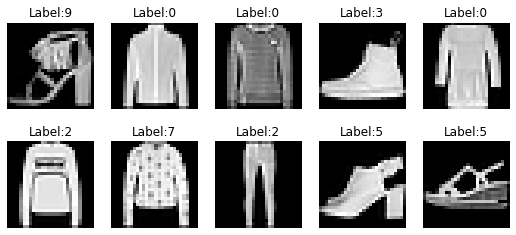

In [ ]:
for i, sample in enumerate(train_loader):
  images, labels = sample
  plot_data(images, train_data.targets.numpy())
  break

#### Define the Autoencoder model
We stack up all our layers to perform encoding first with ReLU activation function. We also have the pooling layer after each convolutional layer. We thus obtain the latent space representation. Further, the decoding of the latent space representation takes place. Again all the ConvTranspose2d() go through the ReLU activation function. [ConvTranspose2d()](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) implements the reverse operation of Conv2d layer i.e reverse of convolution operation. The final decoding layer is coupled with the sigmoid activation function.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x

In [ ]:
# Build the model object and put on the device
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


#### Define Loss function

In [ ]:
# Reconstuction loss (to compare original and reconstructed image)
loss_func = nn.MSELoss() # mean squared error loss

#### Define optimizer

In [ ]:
# Basic SGD optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#### Train the model
Function to add Gaussian noise to the image

In [ ]:
def add_noise(image, mean=0., std=0.2):
  return image + torch.randn(image.size()) * std + mean

Helper function for training/testing

In [ ]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, _) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()    

      # Add noise to image
      noisy_images = add_noise(images)


      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass with noisy data
      output = model(noisy_images)

      # Calculate loss with reconstructed images and original images
      loss = loss_func(output, images)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      epoch_loss = running_loss / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    print ('Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

  return train_losses

In [ ]:
def test(model, test_loader):
  # Eval mode
  model.eval()
  test_acc = 0
  correct = 0
  add_noise = AddGaussianNoise()
  for i, (images, labels) in enumerate(test_loader):
    # Deactivate autograd engine (don't compute grads since we're not training)
    with torch.no_grad():
      # Add noise to image
      noisy_images = add_noise(images)
      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass
      output = model(noisy_images)
    break

  # Plot the noisy and corresponding reconstructed images
  plot_data(noisy_images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)
  plot_data(images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)

Start training

In [ ]:
num_epochs = 5  # iterations
train_losses = train(num_epochs, model, train_loader, loss_func, optimizer)

Epoch 1/5, Loss: 0.0012
Epoch 2/5, Loss: 0.0010
Epoch 3/5, Loss: 0.0010
Epoch 4/5, Loss: 0.0010
Epoch 5/5, Loss: 0.0010


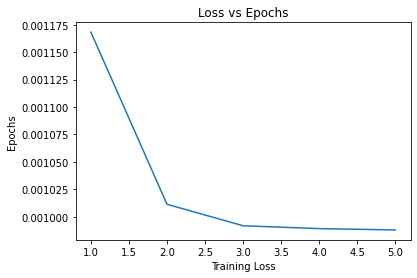

In [ ]:
plt.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training Loss')
plt.ylabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

#### Evaluate the model

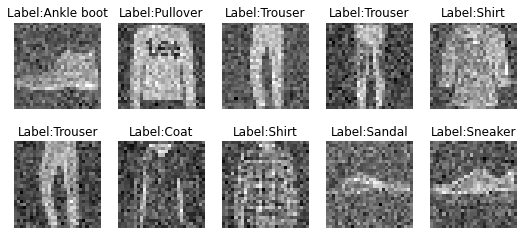

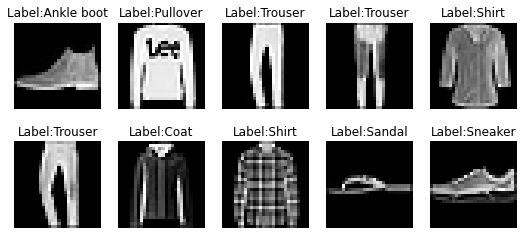

In [ ]:
# Evaluate the model on testing data and plot predictions
test(model, test_loader)

As you can observe, the network learns to remove noise from the images and produce a cleaner version. Now, the encoder of the network which has already learnt important features from the dataset can be further used to perform classification.

## Exercises

Q 1: If you recall, in the first lab exercise, you calculated the shape of output map when a 500 x 500 image is convolved with a 5 x 5 kernel, padding 3 and stride 2. Let's say we apply ConvTranspose2d on this output map. Can you calculate the size of the resultant image? Do you think the size would be same as original image (500 x 500)?

Answer:

Q 2: List a few practical applications of convolutional autoencoders.

Answer:


Q 3: The loss function we chose here was Mean Squared Error loss. Which loss function would you choose if the input data was binary?

Answer:

Q 4: What change do we need to make for the autoencoder to reduce into PCA?

Answer:

Q 5: We want to perform clustering on MNIST data. What advantage we can get if we use bottleneck layer features of a CNN autoencoder for clustering instead of raw images?

Answer:

## References and Additional Resources:

*   [Autoencoder Neural Network: Application to Image Denoising](https://debuggercafe.com/autoencoder-neural-network-application-to-image-denoising/)
*   [Deep inside: Autoencoders - Medium Article](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)
*   [Denoising autoencoder for CIFAR10](https://codahead.com/blog/a-denoising-autoencoder-for-cifar-datasets)
*   [Autoencoders: Overview of Research and Applications](https://towardsdatascience.com/autoencoders-overview-of-research-and-applications-86135f7c0d35)
*   [AutoEncoders](https://www.jeremyjordan.me/autoencoders/)


